<a href="https://colab.research.google.com/github/jdlg-42/TFG/blob/main/distancias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install igraph
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 27.1 MB/s eta 0:00:00


# Código para generar grafos de PSN

In [38]:
# Diccionario de sitios importantes

sites = {
    "A2A_adenosine": [168, 169, 253, 277, 278],
    "A2A_G": [102, 110, 227, 231, 235],
    "beta2AR_epi_4ldo": [1113, 1114, 1193, 1203],
    "beta2AR_epi_3sn6": [113, 114, 193, 203],
    "beta2AR_G_4ldo":[1127, 1135, 1271, 1278],
    "beta2AR_G_3sn6":[134, 135, 138, 139, 229]
    }

In [75]:
# Diccionarios de posición
  # Esta función genera un diccionario que almacena la equivalencia entre la
  # posición real del amino ácido y la posición recogida en la estructura en
  # formato .pdb

from Bio.PDB import PDBParser
from Bio.Data.IUPACData import protein_letters_3to1

# Función auxiliar para convertir 3 letras a 1, con nombres capitalizados
def convertir_nombre_residuo(resname):
    tres_a_una = {
        'ALA': 'Ala', 'ARG': 'Arg', 'ASN': 'Asn', 'ASP': 'Asp',
        'CYS': 'Cys', 'GLN': 'Gln', 'GLU': 'Glu', 'GLY': 'Gly',
        'HIS': 'His', 'ILE': 'Ile', 'LEU': 'Leu', 'LYS': 'Lys',
        'MET': 'Met', 'PHE': 'Phe', 'PRO': 'Pro', 'SER': 'Ser',
        'THR': 'Thr', 'TRP': 'Trp', 'TYR': 'Tyr', 'VAL': 'Val'
    }
    return tres_a_una.get(resname.upper(), resname.capitalize())

def crear_diccionario_residuos(pdb_file, cadena_id="A"):
    parser = PDBParser(QUIET=True)
    estructura = parser.get_structure("estructura", pdb_file)
    modelo = estructura[0]
    cadena = modelo[cadena_id]

    resnum_to_respos = {}
    for residuo in cadena:
        if residuo.id[0] != " ":  # Excluye HETATM y aguas
            continue
        resname = convertir_nombre_residuo(residuo.resname)
        resnum = residuo.id[1]  # auth position
        resnum_to_respos[resnum] = f"{resname}{resnum}"

    return resnum_to_respos

# Ejemplo de uso
pdb_path = "pdb2ydo.pdb"
resnum_to_respos = crear_diccionario_residuos(pdb_path, cadena_id="A")

Para receptor A2A de adenosina:

* 2YDO: cadena A, sites["A2A_adenosine"], sites["A2A_G"]
* 5G53: cadena A, sites["A2A_adenosine"], sites["A2A_G"]

Para receptor beta-2 adrenérgico:
* 4LDO: cadena A, sites["beta2AR_epi4ldo"], sites["beta2AR_G"]
* 3SN6: cadena R, sites["beta2AR_epi3sn6"], sites["beta2AR_G"]

In [71]:
# Configuración de secuencia y sitios alostérico y ortostérico
  # modificar para analizar el grafo para cada ID específico de interés

pdb_id = "2ydo".lower()
chain_id = "A"
sitio_A = sites["A2A_adenosine"] # sitio de unión del ligando alostérico
sitio_O = sites["A2A_G"] # sitio de unión de la proteína G

Desde aqui
[('A', 6, ''), ('A', 7, ''), ('A', 8, ''), ('A', 9, ''), ('A', 10, ''), ('A', 11, ''), ('A', 12, ''), ('A', 13, ''), ('A', 14, ''), ('A', 15, ''), ('A', 16, ''), ('A', 17, ''), ('A', 18, ''), ('A', 19, ''), ('A', 20, ''), ('A', 21, ''), ('A', 22, ''), ('A', 23, ''), ('A', 24, ''), ('A', 25, ''), ('A', 26, ''), ('A', 27, ''), ('A', 28, ''), ('A', 29, ''), ('A', 30, ''), ('A', 31, ''), ('A', 32, ''), ('A', 33, ''), ('A', 34, ''), ('A', 35, ''), ('A', 36, ''), ('A', 37, ''), ('A', 38, ''), ('A', 39, ''), ('A', 40, ''), ('A', 41, ''), ('A', 42, ''), ('A', 43, ''), ('A', 44, ''), ('A', 45, ''), ('A', 46, ''), ('A', 47, ''), ('A', 48, ''), ('A', 49, ''), ('A', 50, ''), ('A', 51, ''), ('A', 52, ''), ('A', 53, ''), ('A', 54, ''), ('A', 55, ''), ('A', 56, ''), ('A', 57, ''), ('A', 58, ''), ('A', 59, ''), ('A', 60, ''), ('A', 61, ''), ('A', 62, ''), ('A', 63, ''), ('A', 64, ''), ('A', 65, ''), ('A', 66, ''), ('A', 67, ''), ('A', 68, ''), ('A', 69, ''), ('A', 70, ''), ('A', 71, ''), ('

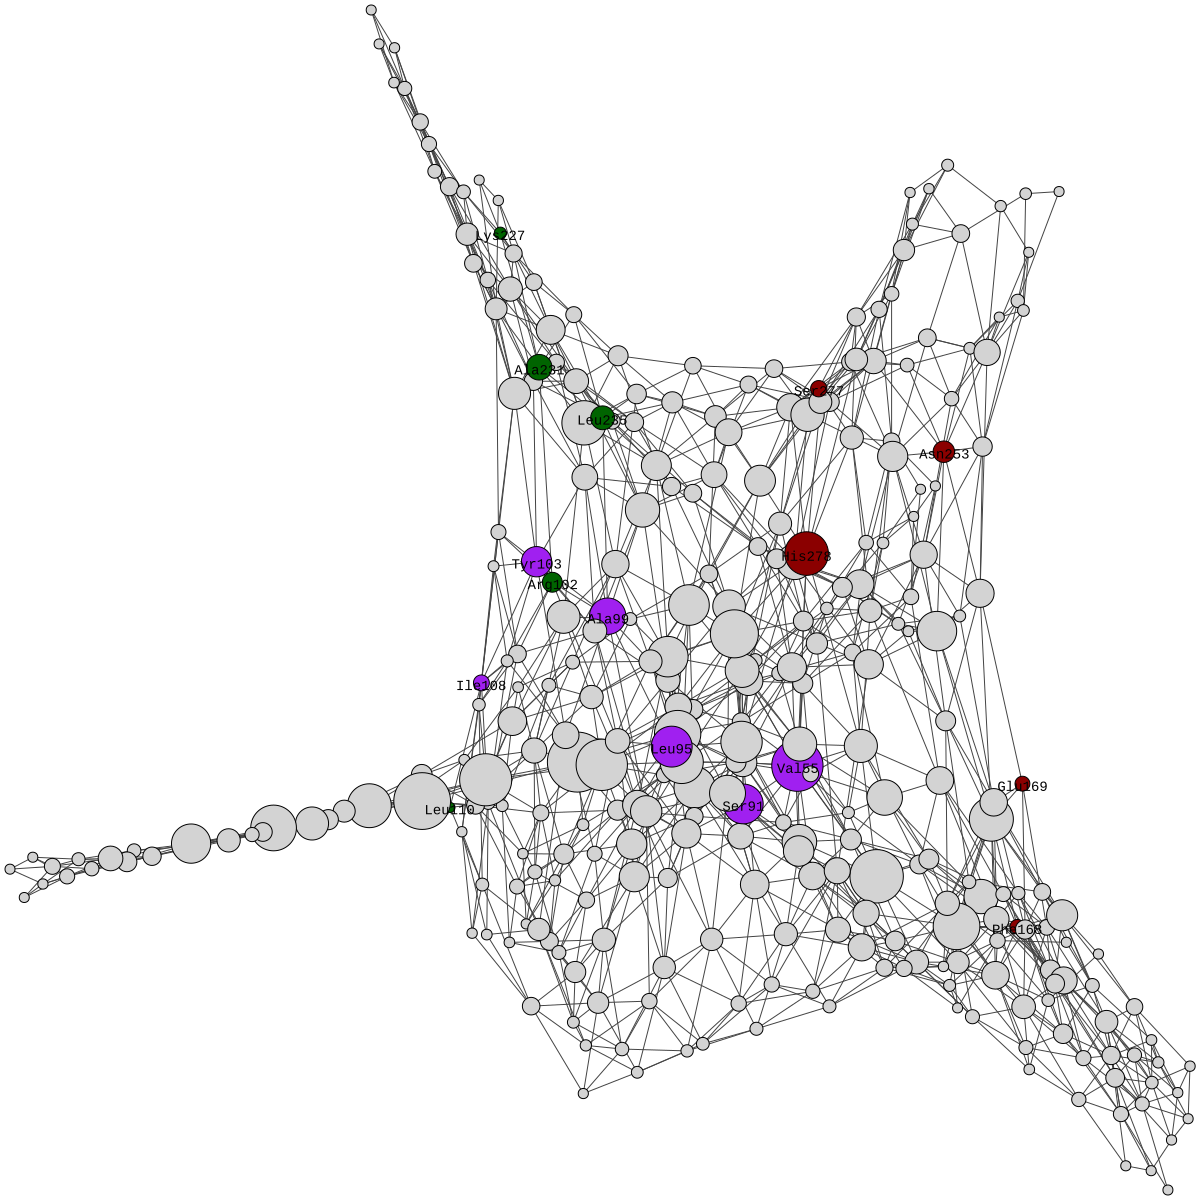

In [76]:
## Grafo de contacto de proteínas ##

# == Comandos de preparación ==

from Bio.PDB import PDBParser
from scipy.spatial import cKDTree
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt
from IPython.display import display, HTML

np.random.seed(42)
random.seed(42)

# Configuración de secuencia y

parser = PDBParser(QUIET=True)
structure = parser.get_structure(f"{pdb_id}", f"pdb{pdb_id}.pdb")

# === Extracción de los CA ===
CA_coord = []
CA_info = []  # lista de tuplas: [(chain_id, resnum, icode), ...]

for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                if "CA" in residue:
                    coord = residue["CA"].get_coord()
                    resid = (chain.id, residue.id[1], residue.id[2].strip())  # ('A', 234, '')
                    CA_coord.append(coord)
                    CA_info.append(resid)

node_to_resid = {idx: resid for idx, resid in enumerate(CA_info)}
resid_to_node = {resid: idx for idx, resid in enumerate(CA_info)}

print("Desde aqui")
print(sorted(resid_to_node.keys()))


# === Árbol de búsqueda y pares ===
tree = cKDTree(CA_coord)
atom_pairs = tree.query_pairs(r=10)

r_min = 4
r_max = 8
atom_pairsfilt = set()
for i, j in atom_pairs:
    dist = np.linalg.norm(CA_coord[i] - CA_coord[j])
    if r_min <= dist <= r_max:
        atom_pairsfilt.add((i, j))

# === Grafo ===

g = ig.Graph()
g.add_vertices(len(CA_coord))
g.add_edges(atom_pairsfilt)

# === Cálculo de caminos más cortos ===

shortest_paths = []
colors = ["gold", "blue", "green", "purple", "orange", "cyan"]  # Lista de colores que se asignarán a los caminos

for a_resid in sitio_A:
    for o_resid in sitio_O:
        key_a = (chain_id, a_resid, "")
        key_o = (chain_id, o_resid, "")
        if key_a in resid_to_node and key_o in resid_to_node:
            a = resid_to_node[key_a]
            o = resid_to_node[key_o]
            try:
                path = g.get_shortest_paths(a, to=o)[0]
                if path:
                    shortest_paths.append({
                        "path": path,
                        "length": len(path),
                        "color": colors[len(shortest_paths) % len(colors)],
                        "nodes": (a_resid, o_resid),
                    })
            except:
                continue

# Calculamos el betweenness de los nodos

g.vs["betweenness"] = g.betweenness()
max_btw = max(g.vs["betweenness"])
min_btw = min(g.vs["betweenness"])

# === Añadir la métrica de centralidad a cada camino más corto ===
for path_info in shortest_paths:
    path = path_info["path"]
    centralities = [g.vs[node]["betweenness"] for node in path]
    path_info["centrality_score"] = np.mean(centralities) # se calcula la media

# === Ordenar los caminos más cortos por suma de betweenness ===
shortest_paths.sort(key=lambda x: x["centrality_score"], reverse=True)

# Escalar tamaños entre 10 y 40
g.vs["size"] = [
    10 + 50 * ((btw - min_btw) / (max_btw - min_btw + 1e-9))
    for btw in g.vs["betweenness"]
]

g.vs["color"] = ["lightgray"]
g.vs["label"] = [None] * len(g.vs)

# === Asignación de colores a los caminos más cortos ===
print("="*50)
print(f"Caminos más cortos ordenados por la medida de centralidad media:")
print("="*50)
for idx, path_info in enumerate(shortest_paths):
    color = path_info["color"]
    path = path_info["path"]
    resid_path = [node_to_resid[n][1] for n in path]  # extrae resnum

    # Imprimir la información de cada shortest path
    print(f"Caminos más cortos entre los nodos {path_info['nodes']} (color: {color}):")
    print(f"Índice: {idx+1}")
    print(f"  Nodos involucrados: {path_info['path']}")
    print(f"  Residuos involucrados (posición): {resid_path}")
    print(f"  Centralidad promedio: {path_info['centrality_score']:.2f}")
    print(f"  Color asignado: {path_info['color']}")
    print("-"*50)

# === Preguntar al usuario qué camino desea visualizar ===
try:
    selection = int(input("Introduce el número del camino más corto que deseas visualizar (0 para ninguno): "))
    if 1 <= selection <= len(shortest_paths):
        chosen_path = shortest_paths[selection - 1]
        for node in chosen_path["path"]:
            g.vs[node]["color"] = chosen_path["color"]
            resid = node_to_resid[node][1]
            label = resnum_to_respos.get(resid, str(resid))
            g.vs[node]["label"] = label
    else:
        print("Número fuera de rango. No se coloreará ningún camino.")
except ValueError:
    print("Entrada no válida. No se coloreará ningún camino.")

# === Sitios de interés ===
for resid in sitio_A:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        node_idx = resid_to_node[key]
        g.vs[node_idx]["color"] = "darkred"
        label = resnum_to_respos.get(resid, str(resid))
        g.vs[node_idx]["label"] = label

for resid in sitio_O:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        node_idx = resid_to_node[key]
        g.vs[node_idx]["color"] = "darkgreen"
        label = resnum_to_respos.get(resid, str(resid))
        g.vs[node_idx]["label"] = label

# === Plot ===
layout = g.layout_fruchterman_reingold()
ig.plot(g, layout=layout, bbox=(1200, 1200), margin=10)

In [64]:
top_n = 50
btw_sorted = sorted(enumerate(g.vs["betweenness"]), key=lambda x: x[1], reverse=True)
top_nodes = [idx for idx, val in btw_sorted[:top_n]]

i=1
print("Top nodos por betweenness centrality en 2YDO:")
for idx in top_nodes:
    print(f"{i}. Nodo {idx}: betweenness = {g.vs[idx]['betweenness']:.2f}")
    i+=1

Top nodos por betweenness centrality en 2YDO:
1. Nodo 185: betweenness = 13091.50
2. Nodo 322: betweenness = 10690.82
3. Nodo 175: betweenness = 10060.33
4. Nodo 181: betweenness = 10043.17
5. Nodo 338: betweenness = 9718.76
6. Nodo 321: betweenness = 8748.68
7. Nodo 168: betweenness = 8251.88
8. Nodo 319: betweenness = 8066.97
9. Nodo 177: betweenness = 8037.02
10. Nodo 171: betweenness = 7328.60
11. Nodo 173: betweenness = 7084.91
12. Nodo 170: betweenness = 7065.64
13. Nodo 342: betweenness = 6520.02
14. Nodo 169: betweenness = 6406.35
15. Nodo 174: betweenness = 6226.74
16. Nodo 333: betweenness = 6137.36
17. Nodo 431: betweenness = 6128.27
18. Nodo 179: betweenness = 5967.10
19. Nodo 178: betweenness = 5518.09
20. Nodo 326: betweenness = 5475.38
21. Nodo 64: betweenness = 5459.33
22. Nodo 224: betweenness = 5410.35
23. Nodo 237: betweenness = 5294.24
24. Nodo 172: betweenness = 5256.44
25. Nodo 233: betweenness = 5052.86
26. Nodo 428: betweenness = 4936.49
27. Nodo 167: betweennes

In [ ]:
## Grafo de contacto de proteínas ##

# == Comandos de preparación ==
from Bio.PDB import PDBParser
from scipy.spatial import cKDTree
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt

np.random.seed(42)
random.seed(42)

# Pruebas

pdb_id = "2ydo".lower()
chain_id = "A"
sitio_A_residues = sites["A2A_adenosine"] # sitio de unión del ligando alostérico
sitio_O_residues = sites["A2A_G"] # sitio de unión de la proteína G

# === Lectura del PDB ===
parser = PDBParser(QUIET=True)
structure = parser.get_structure(f"{pdb_id}", f"pdb{pdb_id}.pdb")

# === Extracción de los CA ===
CA_coord = []
CA_resnums = []  # Número real del residuo
for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                if "CA" in residue:
                    CA_coord.append(residue["CA"].get_coord())
                    CA_resnums.append(residue.id[1])  # Número de residuo

# Crear mapeo: número de residuo → índice de nodo
resnum_to_node = {resnum: idx+1 for idx, resnum in enumerate(CA_resnums)}
print(resnum_to_node)

# === (Opcional) Extracción del ligando ===
alig_list = []
alig_coord = []

# atom_coord contiene CA + ligando (si lo hay)
atom_coord = CA_coord + alig_coord

# === Árbol de búsqueda y filtrado de pares ===
tree = cKDTree(atom_coord)
atom_pairs = tree.query_pairs(r=10)

r_min = 4
r_max = 8
atom_pairsfilt = set()
for i, j in atom_pairs:
    dist = np.linalg.norm(atom_coord[i] - atom_coord[j])
    if r_min <= dist <= r_max:
        atom_pairsfilt.add((i, j))

# === Creación del grafo ===
g = ig.Graph()
g.add_vertices(len(atom_coord))
for i, j in atom_pairsfilt:
    g.add_edge(i, j)

# === Definir sitios A y O (convertir de número de residuo a índice de nodo) ===
sitio_A = [resnum_to_node[r] for r in sitio_A_residues if r in resnum_to_node]
sitio_O = [resnum_to_node[r] for r in sitio_O_residues if r in resnum_to_node]

print(sitio_A, sitio_O)

# === Cálculo de caminos más cortos ===
shortest_paths = []
colors = ["gold", "blue", "green", "purple", "orange", "cyan"]

for a in sitio_A:
    for o in sitio_O:
        try:
            path = g.get_shortest_paths(a, to=o)[0]
            if path:
                shortest_paths.append({
                    "path": path,
                    "length": len(path),
                    "color": colors[len(shortest_paths) % len(colors)],
                    "nodes": (a, o)
                })
        except:
            continue

# === Betweenness y escalado de tamaño de nodos ===
g.vs["betweenness"] = g.betweenness()
max_btw = max(g.vs["betweenness"])
min_btw = min(g.vs["betweenness"])
g.vs["size"] = [
    10 + 30 * ((btw - min_btw) / (max_btw - min_btw + 1e-9))
    for btw in g.vs["betweenness"]
]

# === Etiquetas ===
#g.vs["label"] = [str(r) for r in CA_resnums] + [None]*len(alig_coord)
g.vs["color"] = ["lightgray"] * len(g.vs)

# === Coloreo de ligando (si lo hay) ===
lig_start_idx = len(CA_coord)
lig_end_idx = lig_start_idx + len(alig_coord)
for i in range(lig_start_idx, lig_end_idx):
    g.vs[i]["color"] = "navy"
    g.vs[i]["label"] = alig_list[i - lig_start_idx]

# === Métrica de centralidad en los caminos más cortos ===
for path_info in shortest_paths:
    path = path_info["path"]
    centralities = [g.vs[node]["betweenness"] for node in path]
    path_info["centrality_score"] = np.mean(centralities)

# Ordenar por centralidad
shortest_paths.sort(key=lambda x: x["centrality_score"], reverse=True)

# === Mostrar caminos más cortos ===
shortest_paths.sort(key=lambda x: x["length"])
for idx, path_info in enumerate(shortest_paths):
    print(f"Caminos más cortos entre los nodos {path_info['nodes']} (color: {path_info['color']}):")
    print(f"Índice: {idx+1}")
    print(f"  Nodos involucrados: {path_info['path']}")
    print(f"  Centralidad total: {path_info['centrality_score']:.2f}")
    print(f"  Longitud del camino: {path_info['length']}")
    print("="*50)

# === Selección de camino para visualización ===
try:
    selection = int(input("Introduce el número del camino más corto que deseas visualizar (0 para no representar ninguno): "))
    if 1 <= selection <= len(shortest_paths):
        chosen_path = shortest_paths[selection - 1]
        path = chosen_path["path"]
        color = chosen_path["color"]
        for node in path:
            g.vs[node]["color"] = color
            g.vs[node]["label"] = str(node)
    else:
        print("Número fuera de rango. No se coloreará ningún camino.")
except ValueError:
    print("Entrada no válida. No se coloreará ningún camino.")

# === Colorear sitios A y O ===
for aa in sitio_A:
    if 0 <= aa < len(g.vs):
        g.vs[aa]["color"] = "darkred"
        g.vs[aa]["label"] = str(aa)

for aa in sitio_O:
    if 0 <= aa < len(g.vs):
        g.vs[aa]["color"] = "darkgreen"
        g.vs[aa]["label"] = str(aa)

# === Visualización final ===
layout = g.layout_fruchterman_reingold()
ig.plot(g, layout=layout, bbox=(1000, 1000), margin=50)


{6: 1, 7: 2, 8: 3, 9: 4, 10: 5, 11: 6, 12: 7, 13: 8, 14: 9, 15: 10, 16: 11, 17: 12, 18: 13, 19: 14, 20: 15, 21: 16, 22: 17, 23: 18, 24: 19, 25: 20, 26: 21, 27: 22, 28: 23, 29: 24, 30: 25, 31: 26, 32: 27, 33: 28, 34: 29, 35: 30, 36: 31, 37: 32, 38: 33, 39: 34, 40: 35, 41: 36, 42: 37, 43: 38, 44: 39, 45: 40, 46: 41, 47: 42, 48: 43, 49: 44, 50: 45, 51: 46, 52: 47, 53: 48, 54: 49, 55: 50, 56: 51, 57: 52, 58: 53, 59: 54, 60: 55, 61: 56, 62: 57, 63: 58, 64: 59, 65: 60, 66: 61, 67: 62, 68: 63, 69: 64, 70: 65, 71: 66, 72: 67, 73: 68, 74: 69, 75: 70, 76: 71, 77: 72, 78: 73, 79: 74, 80: 75, 81: 76, 82: 77, 83: 78, 84: 79, 85: 80, 86: 81, 87: 82, 88: 83, 89: 84, 90: 85, 91: 86, 92: 87, 93: 88, 94: 89, 95: 90, 96: 91, 97: 92, 98: 93, 99: 94, 100: 95, 101: 96, 102: 97, 103: 98, 104: 99, 105: 100, 106: 101, 107: 102, 108: 103, 109: 104, 110: 105, 111: 106, 112: 107, 113: 108, 114: 109, 115: 110, 116: 111, 117: 112, 118: 113, 119: 114, 120: 115, 121: 116, 122: 117, 123: 118, 124: 119, 125: 120, 126: 

KeyboardInterrupt: Interrupted by user